In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/kaggle/input/quora-pair/train.csv')

In [3]:
df = df.sample(100000)

In [4]:
df = df.dropna()

# EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 337399 to 9619
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            100000 non-null  int64 
 1   qid1          100000 non-null  int64 
 2   qid2          100000 non-null  int64 
 3   question1     100000 non-null  object
 4   question2     100000 non-null  object
 5   is_duplicate  100000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 5.3+ MB


In [6]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df['is_duplicate'].value_counts()*100/df["is_duplicate"].count()

is_duplicate
0    63.102
1    36.898
Name: count, dtype: float64

<Axes: xlabel='is_duplicate'>

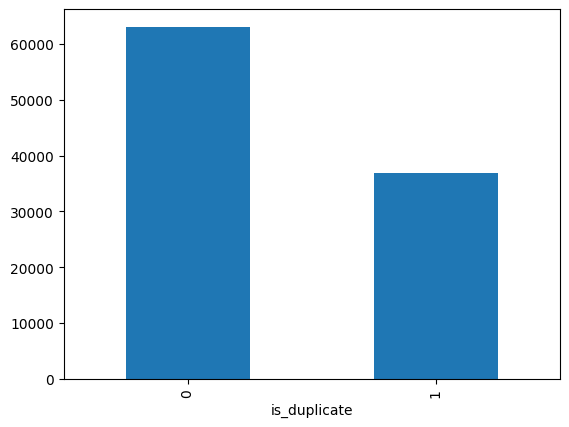

In [9]:
df['is_duplicate'].value_counts().plot(kind='bar')

In [10]:
qid = pd.Series(df['qid1'].tolist()+df['qid2'].tolist())
print(f"number of unique questions : {np.unique(qid).shape[0]}")
x = qid.value_counts()>1
print(f"number of repeated questions : {x[x].shape[0]}")

number of unique questions : 166158
number of repeated questions : 19297


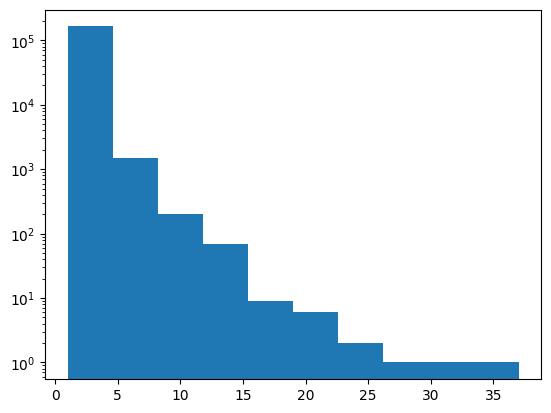

In [11]:
plt.hist(qid.value_counts().values)
plt.yscale('log')
plt.show()

# Basice model and BOW

In [12]:
df = df.sample(30000)

In [13]:
quest_df = df[['question1','question2']]

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
questions = list(quest_df['question1'])+list(quest_df['question2'])

In [16]:
cv = CountVectorizer(max_features = 4000)

In [17]:
q1_arr,q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [18]:
temp_df1 = pd.DataFrame(q1_arr,index = quest_df.index)
temp_df2 = pd.DataFrame(q2_arr,index = quest_df.index)

In [19]:
temp_df = pd.concat([temp_df1,temp_df2],axis=1)

In [20]:
temp_df['is_duplicate'] = df['is_duplicate']

In [21]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(temp_df.iloc[:,0:-1].values,temp_df.iloc[:,-1].values,test_size=0.2,random_state=1)

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.7425

In [23]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
accuracy_score(y_test,y_pred)

0.72

# Advanced feature engineering

In [24]:
df = pd.read_csv('/kaggle/input/quora-pair/train.csv')

In [25]:
df = df.dropna()

In [26]:
df = df.sample(50000)

In [27]:
df['q1_length'] = df['question1'].str.len()
df['q2_length'] = df['question2'].str.len()

In [28]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_length,q2_length
119939,119939,194627,194628,Do you think that the degeneration theory affe...,How did the degeneration theory affect society?,0,91,47
2225,2225,4427,4428,How can I gain weight as an 18 year old girl?,How do I gain weight as a teenager?,1,45,35
348156,348156,165537,350208,How could I be gay?,Is there a way to not be gay?,0,19,29
349758,349758,95648,73344,Where is the wildest place you ever had sex?,Where is the oddest place you've had sex?,1,44,41
91788,91788,153758,153759,Which is the best way to start learning Elasti...,I want to start learning PHP. What is best way...,0,54,56


In [29]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
q1_length       0
q2_length       0
dtype: int64

In [30]:
df = df.dropna()

In [31]:
df['q1_num_words'] = df['question1'].apply(lambda x : len(x.split(" ")) )
df['q2_num_words'] = df['question2'].apply(lambda x : len(x.split(" ")) )

In [32]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_length,q2_length,q1_num_words,q2_num_words
119939,119939,194627,194628,Do you think that the degeneration theory affe...,How did the degeneration theory affect society?,0,91,47,15,7
2225,2225,4427,4428,How can I gain weight as an 18 year old girl?,How do I gain weight as a teenager?,1,45,35,11,8
348156,348156,165537,350208,How could I be gay?,Is there a way to not be gay?,0,19,29,5,8
349758,349758,95648,73344,Where is the wildest place you ever had sex?,Where is the oddest place you've had sex?,1,44,41,9,8
91788,91788,153758,153759,Which is the best way to start learning Elasti...,I want to start learning PHP. What is best way...,0,54,56,9,12


In [33]:
def common_words(row):
  w1 = set(map(lambda x : x.lower().strip(),row['question1'].split(" ")))
  w2 = set(map(lambda x : x.lower().strip(),row['question2'].split(" ")))

  return len(w1 & w2)

In [34]:
df['common_word'] = df.apply(common_words,axis=1)

In [35]:
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return (len(w1) + len(w2))

In [36]:
df['total_words'] = df.apply(total_words,axis=1)

In [37]:
new_df['word_share'] = round(new_df['word_common']/new_df['word_total'],2)
new_df.head()

NameError: name 'new_df' is not defined

In [38]:
df['word_share'] = round(df['common_word']/df['total_words'],2)

In [ ]:
sns.displot(df['q1_length'])
print(f"length of min word : {df['q1_length'].min()}")
print(f"length of max word : {df['q1_length'].max()}")
print(f"avg word length: {df['q1_length'].mean()}")

In [ ]:
sns.displot(df['q2_length'])
print(f"length of min word : {df['q2_length'].min()}")
print(f"length of max word : {df['q2_length'].max()}")
print(f"avg word length: {df['q2_length'].mean()}")

In [ ]:
sns.displot(df['q1_num_words'])
print(f"length of min word : {df['q1_num_words'].min()}")
print(f"length of max word : {df['q1_num_words'].max()}")
print(f"avg word length: {df['q1_num_words'].mean()}")

In [ ]:
sns.displot(df['q2_num_words'])
print(f"length of min word : {df['q2_num_words'].min()}")
print(f"length of max word : {df['q2_num_words'].max()}")
print(f"avg word length: {df['q2_num_words'].mean()}")

In [ ]:
sns.distplot(df[df['is_duplicate']==0]['common_word'],label = 'not duplicated')
sns.distplot(df[df['is_duplicate']==1]['common_word'],label = 'duplicated')
plt.legend()
plt.show()

In [ ]:
sns.distplot(df[df['is_duplicate']==0]['total_words'],label = 'not duplicated')
sns.distplot(df[df['is_duplicate']==1]['total_words'],label = 'duplicated')
plt.legend()
plt.show()

In [ ]:
sns.distplot(df[df['is_duplicate']==0]['word_share'],label = 'not duplicated')
sns.distplot(df[df['is_duplicate']==1]['word_share'],label = 'duplicated')
plt.legend()
plt.show()

In [39]:
ques_df = df[['question1','question2']]
ques_df.head()

,question1,question2
119939,Do you think that the degeneration theory affe...,How did the degeneration theory affect society?
2225,How can I gain weight as an 18 year old girl?,How do I gain weight as a teenager?
348156,How could I be gay?,Is there a way to not be gay?
349758,Where is the wildest place you ever had sex?,Where is the oddest place you've had sex?
91788,Which is the best way to start learning Elasti...,I want to start learning PHP. What is best way...


In [40]:
ques_df.shape

(50000, 2)

In [41]:
final_df = df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(50000, 8)


,is_duplicate,q1_length,q2_length,q1_num_words,q2_num_words,common_word,total_words,word_share
119939,0,91,47,15,7,3,22,0.14
2225,1,45,35,11,8,5,19,0.26
348156,0,19,29,5,8,2,13,0.15
349758,1,44,41,9,8,6,17,0.35
91788,0,54,56,9,12,6,20,0.30


In [42]:
questions = list(ques_df['question1'])+list(ques_df['question2'])

In [43]:
cv1 = CountVectorizer(max_features=5000)
q1_arr, q2_arr = np.vsplit(cv1.fit_transform(questions).toarray(),2)

In [44]:
q1_arr.shape

(50000, 5000)

In [45]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(50000, 10000)

In [46]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(50000, 10008)


,is_duplicate,q1_length,q2_length,q1_num_words,q2_num_words,common_word,total_words,word_share,0,1,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
119939,0,91,47,15,7,3,22,0.14,0,0,...,0,0,0,0,0,0,0,0,0,0
2225,1,45,35,11,8,5,19,0.26,0,0,...,0,0,0,0,0,0,0,0,0,0
348156,0,19,29,5,8,2,13,0.15,0,0,...,0,0,0,0,0,0,0,0,0,0
349758,1,44,41,9,8,6,17,0.35,0,0,...,0,0,0,0,0,0,0,0,0,0
91788,0,54,56,9,12,6,20,0.30,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=1)

In [52]:
X_train[0][:7]

array([69.  , 36.  , 16.  ,  9.  ,  8.  , 22.  ,  0.36])

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.7827

In [54]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
accuracy_score(y_test,y_pred)

0.7742

In [55]:
def query_point_creator(q1,q2):
    
    input_query = []
    
    input_query.append(len(q1))
    input_query.append(len(q2))
    
    
    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))
    
    q1 = q1.lower()
    q2 = q2.lower()
    
    temp = len((set(q1.split(" "))) & (set(q2.split(" "))))
    input_query.append(temp)
    
    temp1 = len((set(q1.split(" ")))) + len((set(q2.split(" "))))
    
    input_query.append(temp)
    
    input_query.append(round(temp/temp1,2))
    
    
    print(input_query)

    # bow feature for q1
    q1_bow = cv1.transform([q1]).toarray()
    
    print(q1_bow.shape)
    
    # bow feature for q2
    q2_bow = cv1.transform([q2]).toarray()
    
    
    
    return np.hstack((np.array(input_query).reshape(1,7),q1_bow,q2_bow))

In [71]:
q1 = 'Where is the capital of India?'
q2 = 'What is the current capital of Pakistan?'
q3 = 'Which city serves as the capital of India?'
q4 = 'What is the business capital of India?'
q5 = "I'm the owner of the house"
q6 = "this land is owned by me"

In [72]:
x = query_point_creator(q5,q6)




[26, 24, 6, 6, 0, 0, 0.0]
(1, 5000)


In [73]:
x[0][:7]

array([26., 24.,  6.,  6.,  0.,  0.,  0.])

In [74]:
rf.predict(x)

array([0])

In [75]:
import pickle

pickle.dump(rf,open('model.pkl','wb'))
pickle.dump(cv1,open('cv.pkl','wb'))